In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
import random
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.scores import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, classification_report
import matplotlib.pyplot as plt

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The **RoBERTa** model used is a *Roberta-cased* fine-tuned implementation, freezing the first 9 layers during training, with the addition of an output layer made of some neurons, responsible for the classification task.<br>
What follows is the work pipeline used on **RoBERTa** model:
1. Cross Validation
2. Cleaning validation
3. Training the final model: *Roberta*
4. Mapping *Roberta* predictions to the Ekman taxonomy
5. Training with the Ekman-mapped training-set the model *Grouped_Roberta*
6. Testing *Roberta* generalizzation capabilities on the twitter dataset

In [2]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.GoEmotionsCleaned
DATASET_UNCLEANED = DatasetEnum.GoEmotions
SEED_VAL = 777
DATASET_NAME = 'GoEmotions'
MODEL_NAME = 'Roberta'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
FROZEN_LAYERS = 9
EPOCHS = 6
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

## 1. Cross Validation
We try to get the best parameters for a Roberta model on the goEmotions dataset

In [3]:
params_to_explore = {
    'learning_rate': [5e-05, 1e-05],
    'regularization': [0, 1e-05],
    'batch_size': [16, 32],
    'epochs': [EPOCHS],
    'frozen_layers': [FROZEN_LAYERS],
    'n_classes': [len(LABEL_COLS)],
}
RESULT_DIR = './results/' + DATASET_NAME + '/'
RESULT_FILE = RESULT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.csv'
# create the grid search object
grid_search = HoldOutCrossValidation(Roberta, SCORES, train_df, val_df, param_dict=params_to_explore, res_file=RESULT_FILE)
# run the grid search
grid_search.run()

0it [00:00, ?it/s]

In [4]:
# load the results
results = grid_search.get_results()
# get the best parameters and scores according to F1 macro
best_info = grid_search.get_best_info('f1_macro')
print("BEST MODEL INFO")
print(best_info)
# print the results
print("RESULTS")
print(results)
print("BEST PARAMS")
BEST_PARAMS = grid_search.get_best_params('f1_macro')
BEST_PARAMS['batch_size'] = int(BEST_PARAMS['batch_size'])
BEST_PARAMS['epochs'] = int(BEST_PARAMS['epochs'])
BEST_PARAMS['frozen_layers'] = int(BEST_PARAMS['frozen_layers'])
BEST_PARAMS['n_classes'] = int(BEST_PARAMS['n_classes'])
print(BEST_PARAMS)

BEST MODEL INFO
{'batch_size': 32.0, 'epochs': 6.0, 'frozen_layers': 9.0, 'learning_rate': 5e-05, 'n_classes': 28.0, 'regularization': 1e-05, 'train_accuracy': 0.5037318590186592, 'train_jaccard_macro': 0.4131293189336031, 'train_f1_macro': 0.5690887372934065, 'train_jaccard_samples': 0.6069016355678416, 'train_f1_micro': 0.6509211883037295, 'train_membership': 0.6852338170928357, 'val_accuracy': 0.4776999631404349, 'val_jaccard_macro': 0.373276503777086, 'val_f1_macro': 0.5254690426346077, 'val_jaccard_samples': 0.5719744440348937, 'val_f1_micro': 0.6097826086956522, 'val_membership': 0.6411721341688168}
RESULTS
   batch_size  epochs  frozen_layers  learning_rate  n_classes  \
0          16       6              9        0.00005         28   
1          32       6              9        0.00005         28   
2          16       6              9        0.00005         28   
3          32       6              9        0.00005         28   
4          16       6              9        0.000

What follows is a training test on a fixed seed (for riproducibility purposes) using the best parameters.

In [5]:
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)
# create the model with the best parameters
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


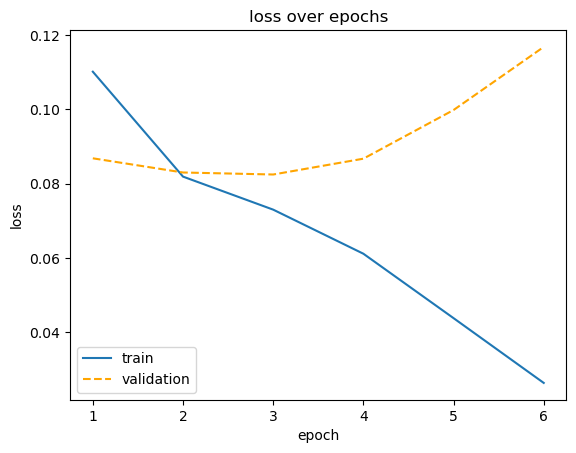

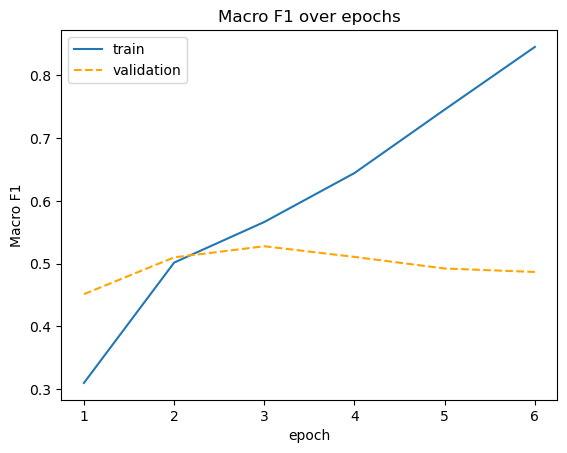

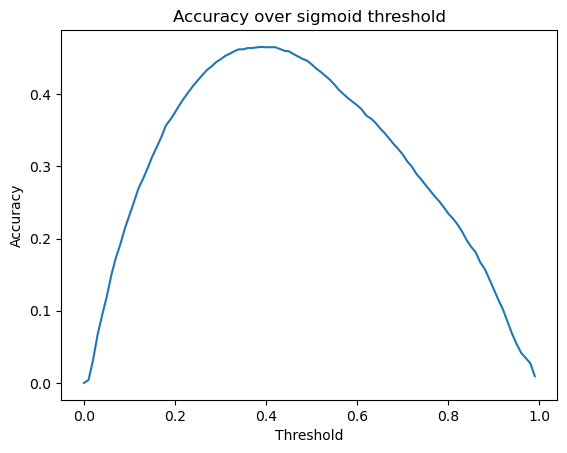

Best threshold: 0.39
Best Accuracy: 0.4655363066715813


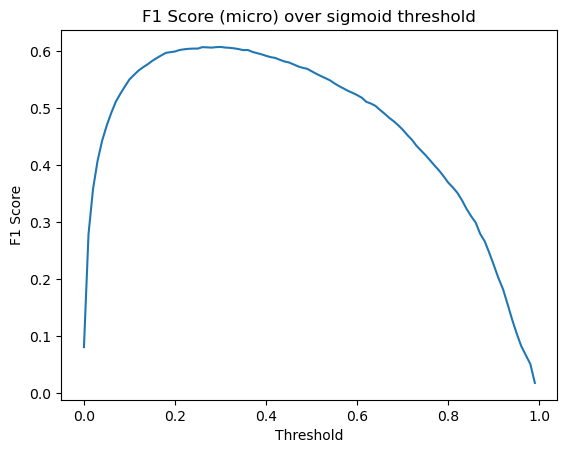

Best threshold: 0.3
Best F1 Score (micro): 0.6078416209109891


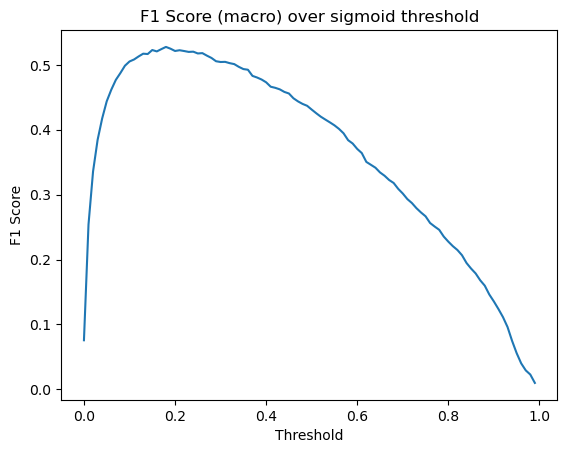

Best threshold: 0.18
Best F1 Score (macro): 0.5275957787305248


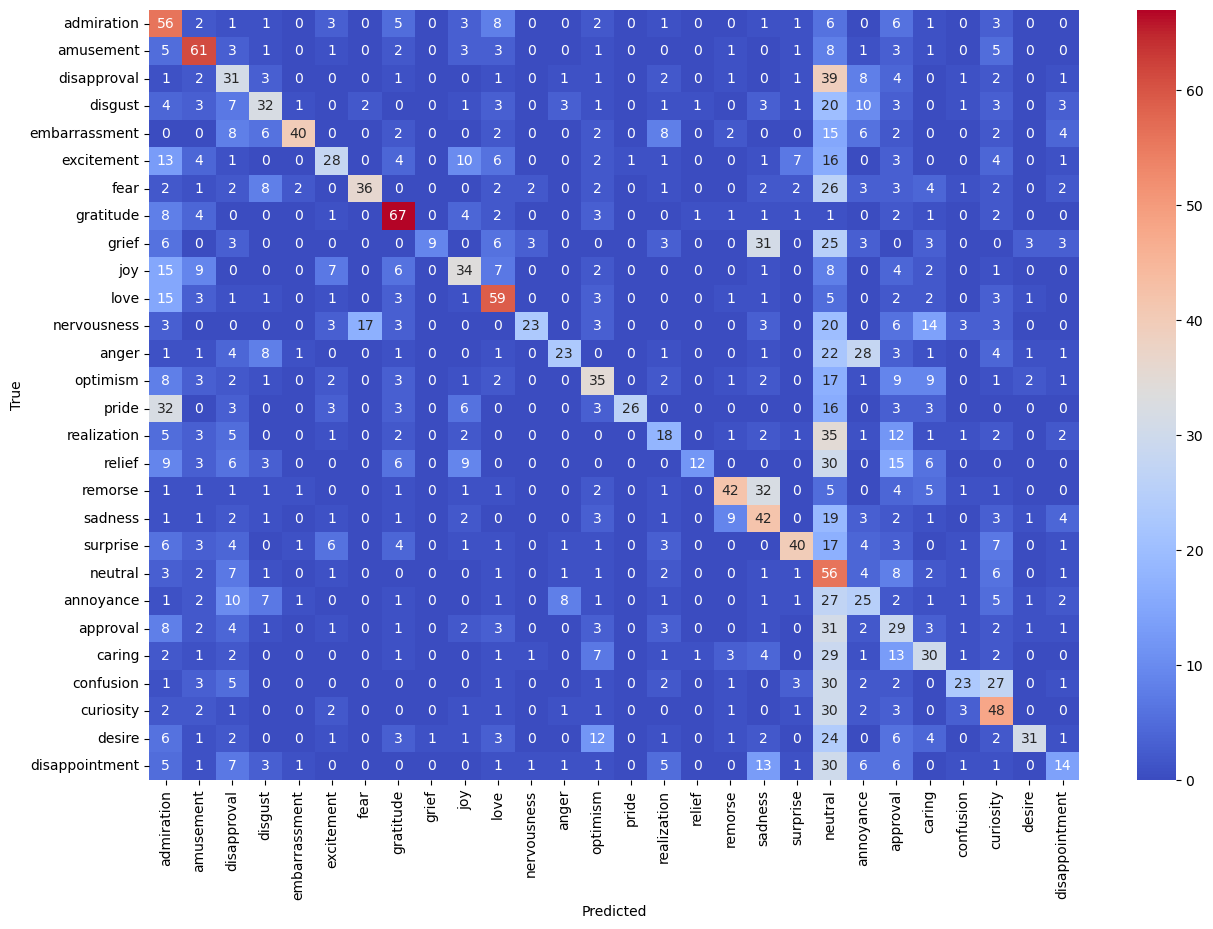

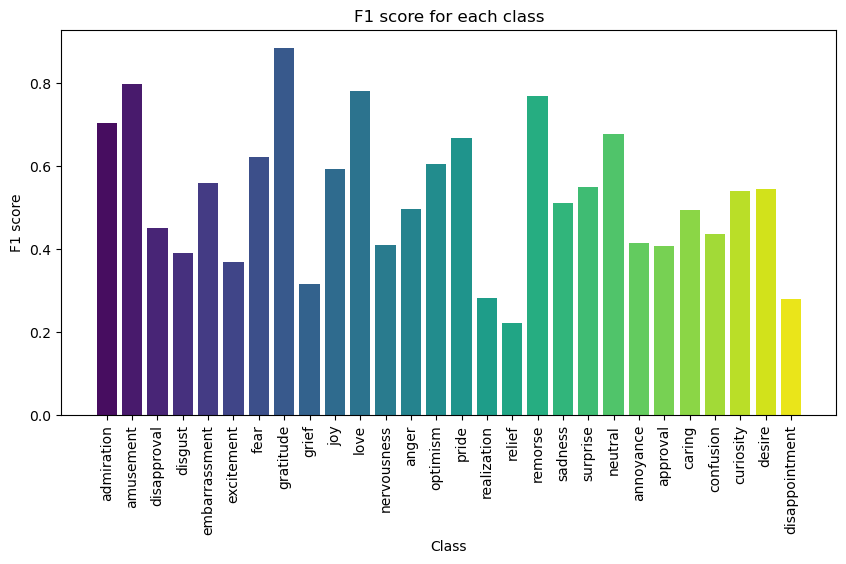

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.60                0.85                0.70                0.54                 488
amusement                           0.72                0.90                0.80                0.66                 303
disapproval                         0.35                0.62                0.45                0.29                 292
disgust                             0.31                0.52                0.39                0.24                  97
embarrassment                       0.58                0.54                0.56                0.39                  35
excitement                          0.30                0.48                0.37                0.23                  96
fear                                0.77                0.52                0.62                0.45                  90
gratitude

In [24]:
model_analysis(model, val_df, LABEL_COLS)

## 2. Cleaning Validation
The cleaning validation consists of a comparison between two models trained using as the training sets, the standard one and a cleaned (using the notebook *GoEmotions_data_preparation*) version of it. In order to make a fair comparison, the seed value responsible for the initializzation of the *roberta* model output layer's weights is fixed for both models, moreover there is no shuffling of the dataset during batch creations.

### Roberta_uncleaned

In [9]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '_uncleaned.pth'
train_df, val_df, test_df = load_dataset(DATASET_UNCLEANED, k_hot_encode=True)
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)
BEST_PARAMS_UNCLEANED = BEST_PARAMS.copy()
BEST_PARAMS_UNCLEANED['tokenizer_max_len'] = 48
# for memory reasons (only few records affected and truncated)

In [6]:
model = Roberta({'f1_macro':f1}, BEST_PARAMS_UNCLEANED, CHECKPOINT_MODEL_FILE)
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True, shuffle_training=False)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_analysis(model, val_df, LABEL_COLS)

In [7]:
out_uncleaned = model.predict(val_df)
target = val_df[LABEL_COLS].values
best_thresh, _ = tune_sigmoid_threshold(target, out_uncleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
out_uncleaned = (out_uncleaned > best_thresh).astype(int)

### Roberta_cleaned

In [8]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '_cleaned_seq.pth'
train_df, val_df, test_df = load_dataset(DATASET)
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

In [9]:
model = Roberta({'f1_macro':f1}, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True, shuffle_training=False)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
out_cleaned = model.predict(val_df)
best_thresh, _ = tune_sigmoid_threshold(target, out_cleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
out_cleaned = (out_cleaned > best_thresh).astype(int)

Now we can compare the graphical results of the obtained models

C:\Users\andre\AppData\Local\Temp\ipykernel_340\3911376436.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(),


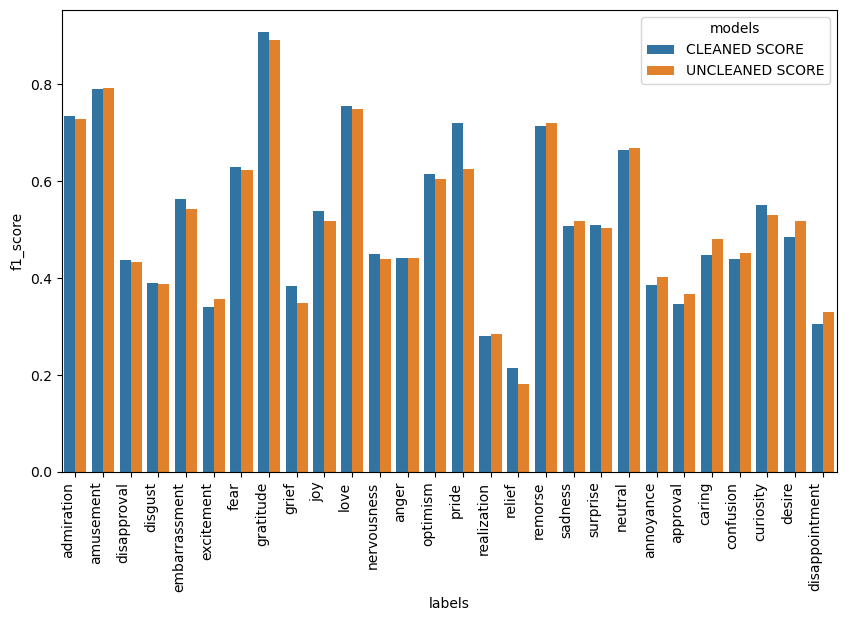

cleaned mean = 0.5196747999692459
uncleaned mean = 0.515492887793536


In [11]:
cleaned_score = f1_score(target, out_cleaned,average=None)
uncleaned_score = f1_score(target, out_uncleaned,average=None)

# we create a dataframe with for each label the f1 score for both the models
results_df=pd.DataFrame(zip(LABEL_COLS,cleaned_score,uncleaned_score),columns=["labels","CLEANED SCORE","UNCLEANED SCORE"])
results_df = pd.melt(results_df, id_vars="labels", var_name="models", value_name="f1_score")
plt.figure(figsize=(10, 6))
barplot=sns.barplot(x="labels", hue="models", y="f1_score", data=results_df)
barplot.set_xticklabels(barplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

print(f"cleaned macro avg = {np.mean(cleaned_score)}\nuncleaned macro avg = {np.mean(uncleaned_score)}")

As we can see, the best model is the **cleaned** one. <br>
As stated in the report, the difference in performances is low and the result is more influenced by the fixed seed than by the the choice between the two datasets, so for consistency reason the final model is trained with the **uncleaned** one anyway.

## 3. Training the final model: *Roberta*
Now we train the final  using the standard training-set version, for reproducibility reason we fix a seed. Since we are using this training set version, by setting a *max-lenght*, the tokenizer will truncate the phrases makes the training a lot faster and less expensive memory-wise.<br>
The choice of **48** as the max_len value is made by analyzing the token count distribution over the dataset on the notebook **GoEmotions_data_exploration**

In [10]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '_best_uncleaned.pth'
train_df, val_df, test_df = load_dataset(DATASET_UNCLEANED, k_hot_encode=True)

In [11]:
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)
# create the model with the best parameters
model = Roberta(SCORES, BEST_PARAMS_UNCLEANED, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

## 4. Mapping *Roberta* predictions to the Ekman taxonomy

In [5]:
train_df, val_df, test_df = load_dataset(DATASET_UNCLEANED, k_hot_encode=True)

In [6]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME  + '_' + MODEL_NAME + '_best_uncleaned.pth'
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# get model predictions on validation set
out = model.predict(val_df)
# get best threshold
thresh, _ = tune_sigmoid_threshold(val_df[LABEL_COLS].values, out, f1_score, metric_params={'average':'macro', 'zero_division':0})

In [8]:
# map dataset emotions to Ekman taxonomy
train_df = goemotions_apply_emotion_mapping(train_df)
val_df = goemotions_apply_emotion_mapping(val_df)
grouped_test_df = goemotions_apply_emotion_mapping(test_df)
# keep only grouped records
test_df = test_df.loc[grouped_test_df.index]
# names starting with 'ekman_' are the mapped emotions
EKMAN_LABELS = grouped_test_df.columns[grouped_test_df.columns.str.startswith('ekman_')].tolist()

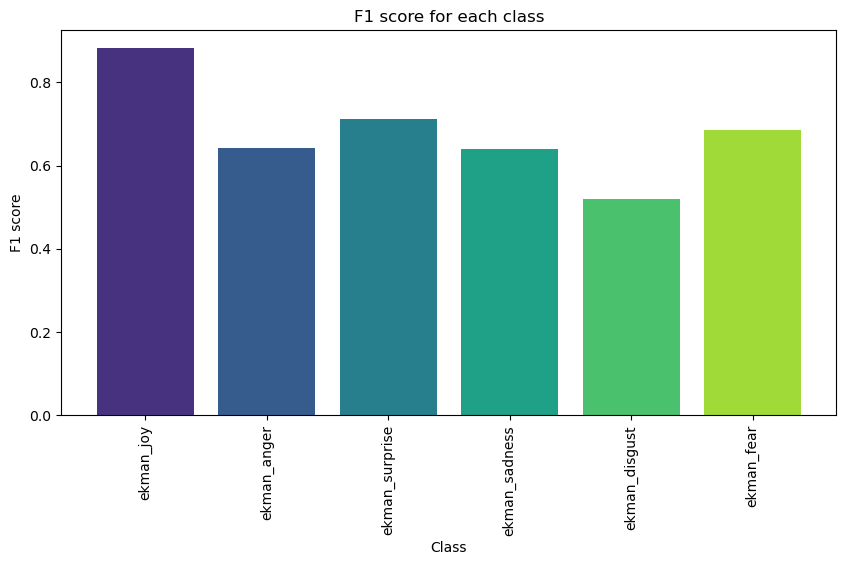

Avg Macro F1 Score: 0.6800576673873846


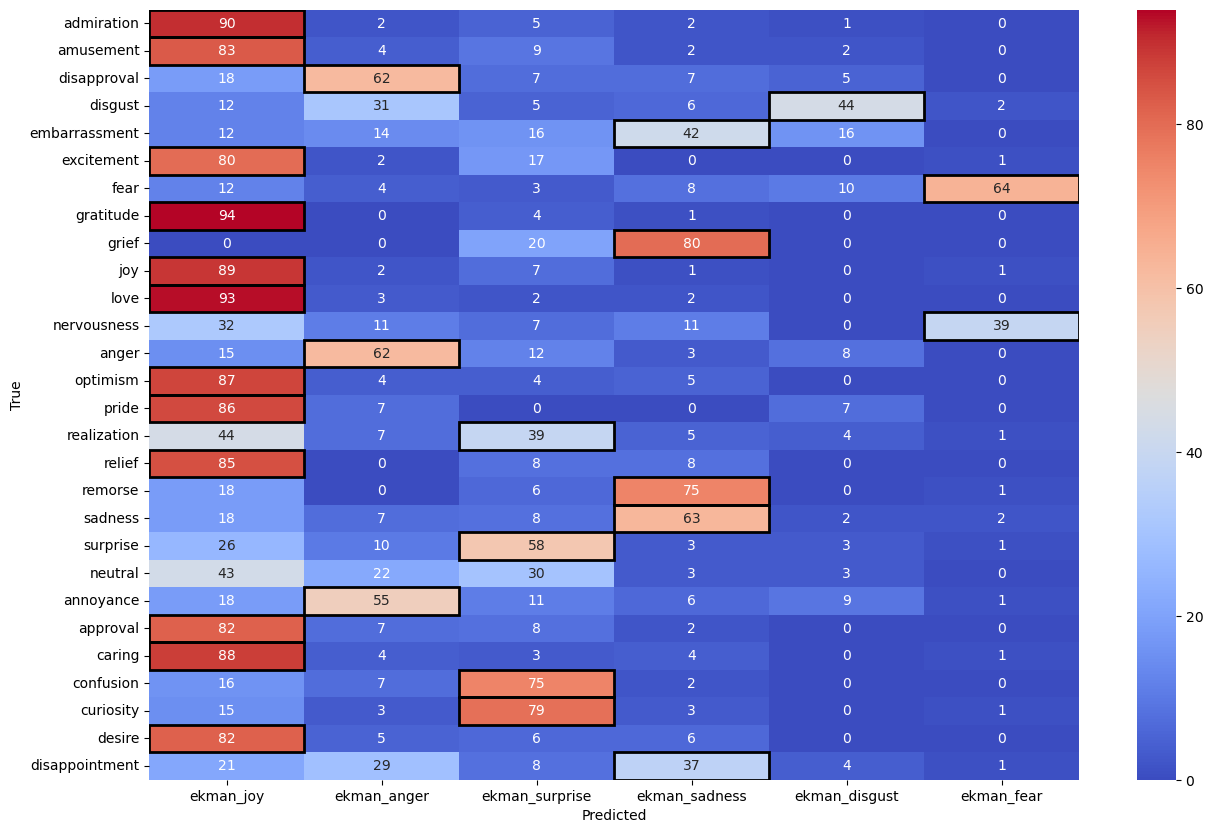

In [9]:
best_out = (model.predict(grouped_test_df) > thresh).astype(int)
best_out = goemotions_apply_emotion_mapping(best_out, isDataframe=False)
# plot bar plot
plot_score_barplot(grouped_test_df[EKMAN_LABELS].values, best_out, EKMAN_LABELS)
# print average f1 score
print(f"Avg Macro F1 Score: {f1_score(grouped_test_df[EKMAN_LABELS].values, best_out, average='macro')}")
# visualize confusion matrix to understand induced mapping
plot_multilabel_confusion_heatmap(test_df[LABEL_COLS].values, best_out, LABEL_COLS, EKMAN_LABELS, normalize=True, transpose=False, highlight_borders_map=GOEMOTIONS_EKMAN_MAPPING, highlight_map_true_to_pred=False)

## 5. Training with the Ekman-mapped training-set the model *Grouped_Roberta*
The dataset entry labelled with neutral emotion are dropped from the dataset: there is no neutral emotion in the Ekman taxonomy.

In [15]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + 'Grouped' + '_' + MODEL_NAME + '_uncleaned.pth'
train_df, val_df, test_df = load_dataset(DATASET_UNCLEANED, k_hot_encode=True)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

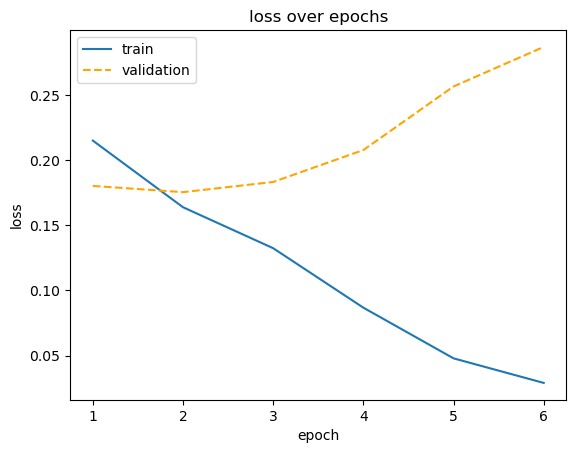

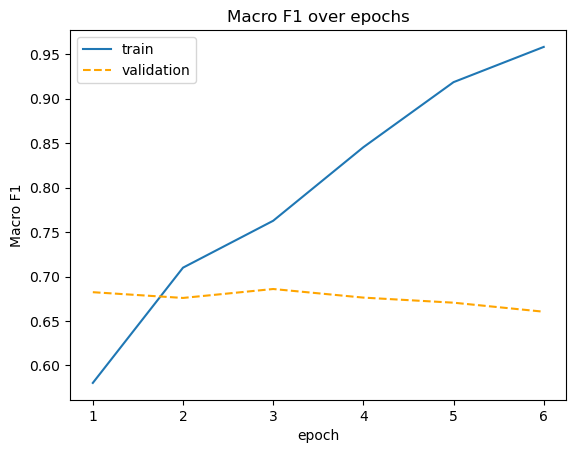

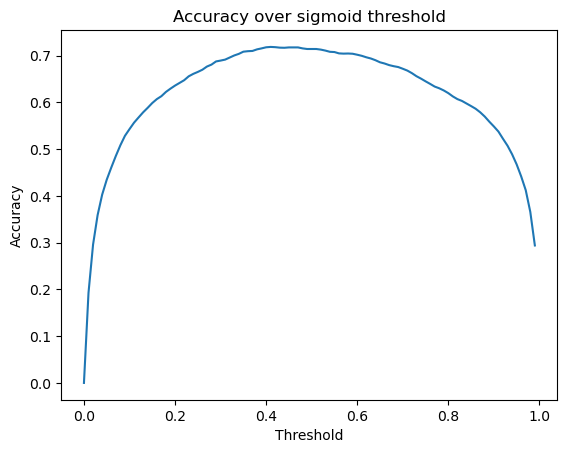

Best threshold: 0.41000000000000003
Best Accuracy: 0.7185706833594158


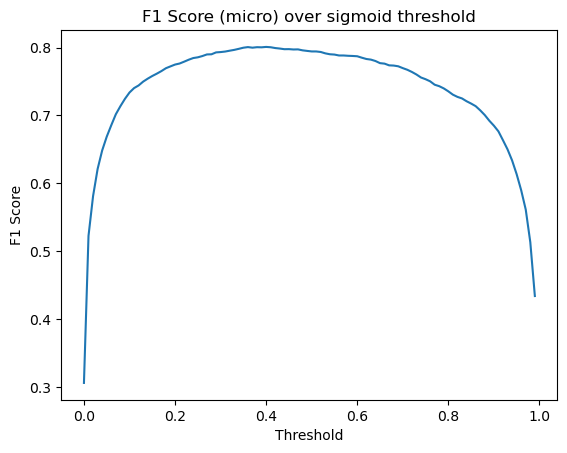

Best threshold: 0.4
Best F1 Score (micro): 0.8010680907877169


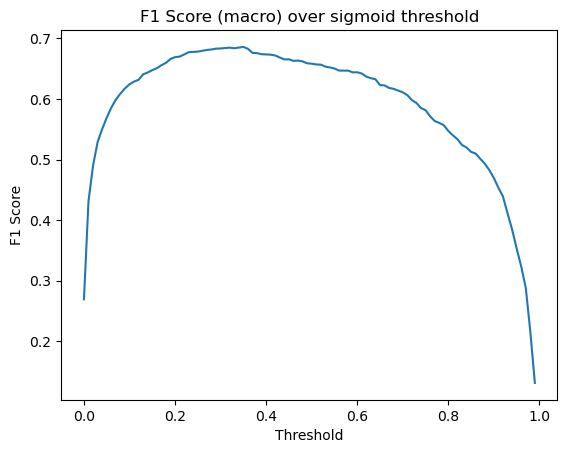

Best threshold: 0.35000000000000003
Best F1 Score (macro): 0.685996972058965


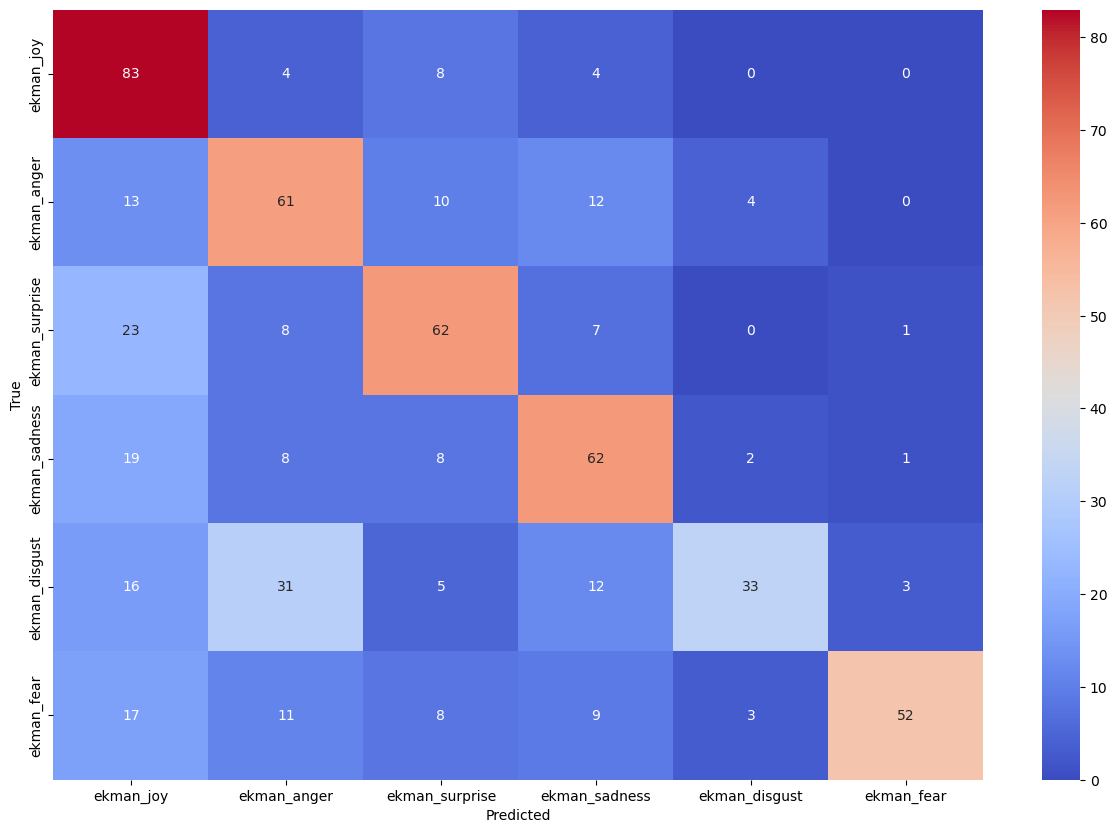

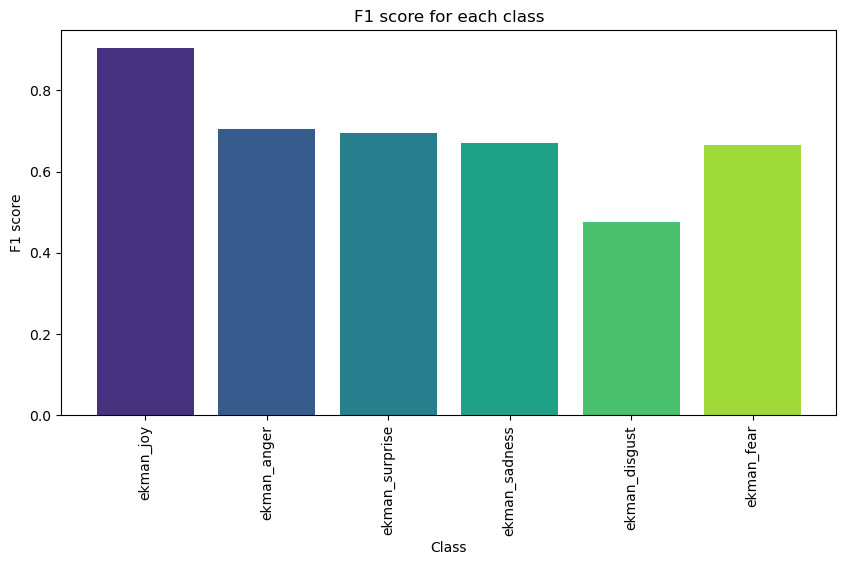

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
ekman_joy                           0.89                0.91                0.90                0.82                2219
ekman_anger                         0.72                0.69                0.70                0.54                 717
ekman_surprise                      0.65                0.74                0.69                0.53                 624
ekman_sadness                       0.62                0.74                0.67                0.51                 390
ekman_disgust                       0.56                0.41                0.48                0.31                  97
ekman_fear                          0.78                0.58                0.67                0.50                 105
Macro avg                           0.70                0.68                0.69                0.54                4152
Micro avg

In [16]:
BEST_PARAMS['n_classes'] = len(EKMAN_LABELS)
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)
# model analysis with Ekman mapped emotions
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)
model_analysis(model, val_df, EKMAN_LABELS)

### Conclusions
Mapping *Roberta* predicted results leads to a macro f1-score of **0.68** while, as we expected, the model *Grouped_Roberta* scores **0.69** on the same metric.

## 6. Testing *Roberta* generalizzation capabilities on the twitter dataset
We used the model *Roberta* to make predictions on twitter test-set. Using the predictions labelled with goemotions labels, we can analyze the generalization capabilities of the model, by comparing the predicted emotions to the actual ones, labelled following the parrot taxonomy (twitter).

In [16]:
DATASET = DatasetEnum.TwitterData
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '_best_uncleaned.pth'
train_df, val_df, test_df = load_dataset(DATASET, k_hot_encode=True)
TWITTER_LABEL = train_df.columns[1:].tolist()

In [17]:
BEST_PARAMS['n_classes'] = len(LABEL_COLS)
# create the model with the best parameters
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    raise Exception("Model not found")

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In the following confusion matrix, for each column (which is related to a twitter emotion), the correctly mapped GoEmotions label is highlighted. The mapping used as the "golden" mapping is chosen by the group members.

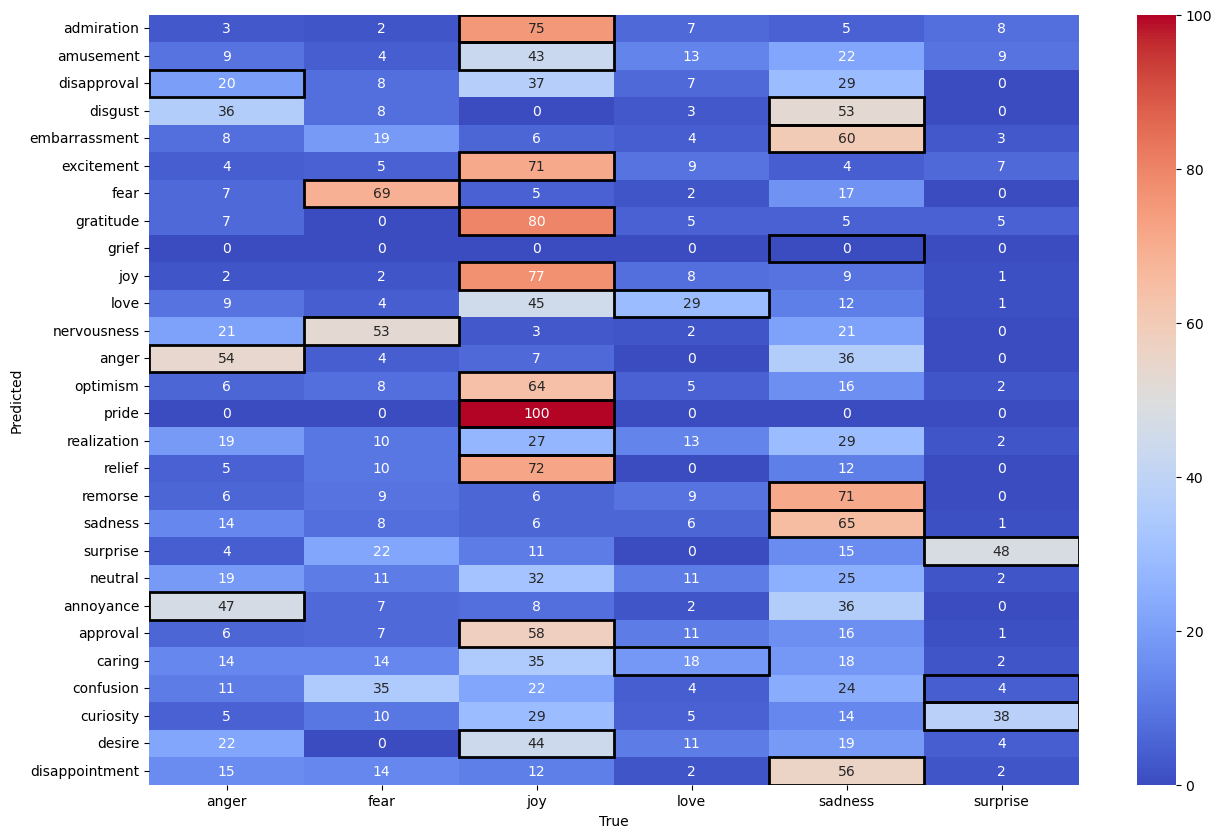

In [19]:
# get model predictions on test set of Twitter dataset
out = model.predict(test_df)
best_out = (out > thresh).astype(int)
# visualize confusion matrix to understand induced mapping
HIGHLIGHT_MAP = {k.replace('twitter_', ''): v for k, v in GOEMOTIONS_TWITTER_MAPPING.items()}
plot_multilabel_confusion_heatmap(test_df[TWITTER_LABEL].values, best_out, TWITTER_LABEL, LABEL_COLS, normalize=True, transpose=True, highlight_borders_map=HIGHLIGHT_MAP)